In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
import json
import json_repair

from typing import List, Dict
from colorama import Fore

from haystack import component, Pipeline
from haystack.dataclasses import Document

from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter

## Components
1. Initialize a component
2. Inspect expected input/output types

In [3]:
embedder = OpenAIDocumentEmbedder(model="text-embedding-3-small")

In [4]:
embedder

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document]
  - meta: Dict[str, Any]

In [5]:
documents = [Document(content="Haystack is an open source AI framework to build full AI applications in Python"),
             Document(content="You can build AI Pipelines by combining Components"),]

embedder.run(documents=documents)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


{'documents': [Document(id=cca6283a4f41557c49df1c5087a6be0ec172815a8d0c811e435caf6b1a93e0b4, content: 'Haystack is an open source AI framework to build full AI applications in Python', embedding: vector of size 1536),
  Document(id=11ee1490e1dc5cd44361b1541008891b0b40aabd4d5bb2da6a2499f23e6120f7, content: 'You can build AI Pipelines by combining Components', embedding: vector of size 1536)],
 'meta': {'model': 'text-embedding-3-small',
  'usage': {'prompt_tokens': 24, 'total_tokens': 24}}}

## Pipelines (Indexing + RAG Pipelines)

1. Add components
2. Connect components

In [6]:
document_store = InMemoryDocumentStore()
document_store.count_documents()

0

In [7]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("fetcher", fetcher)
indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [8]:
indexing_pipeline.connect("fetcher", "converter")
indexing_pipeline.connect("converter", "embedder")
indexing_pipeline.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

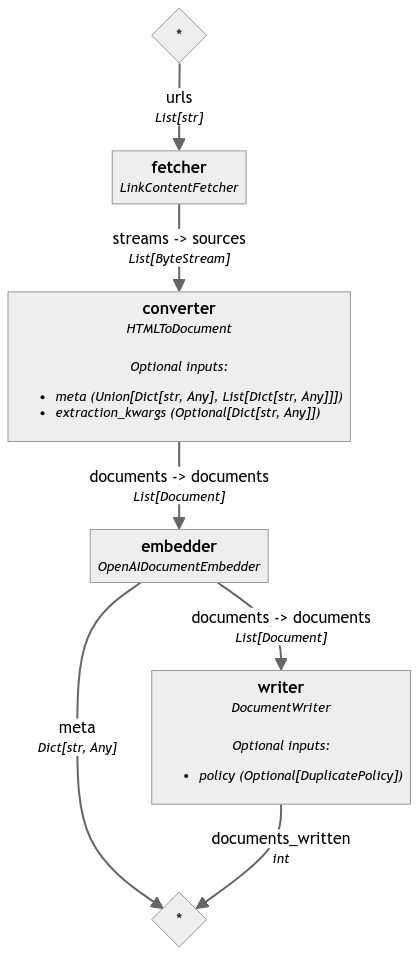

In [9]:
indexing_pipeline.show()

In [10]:
indexing_pipeline.run({"fetcher": {"urls": ["https://haystack.deepset.ai/integrations/mistral", 
                                            "https://haystack.deepset.ai/integrations/cohere"]}})

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 3075, 'total_tokens': 3075}}},
 'writer': {'documents_written': 2}}

In [11]:
document_store.count_documents()

2

### RAG

In [12]:
prompt_template = """Answer the question given the following documents. 
Documents:
{% for document in documents %}
    {{document.content}}
{% endfor %}
Question: {{query}}
Answer:
 """

In [13]:
query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt = PromptBuilder(template=prompt_template)
llm = OpenAIGenerator(model="gpt-4")

rag = Pipeline()

rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt)
rag.add_component("llm", llm)


rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "llm")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> llm.prompt (str)

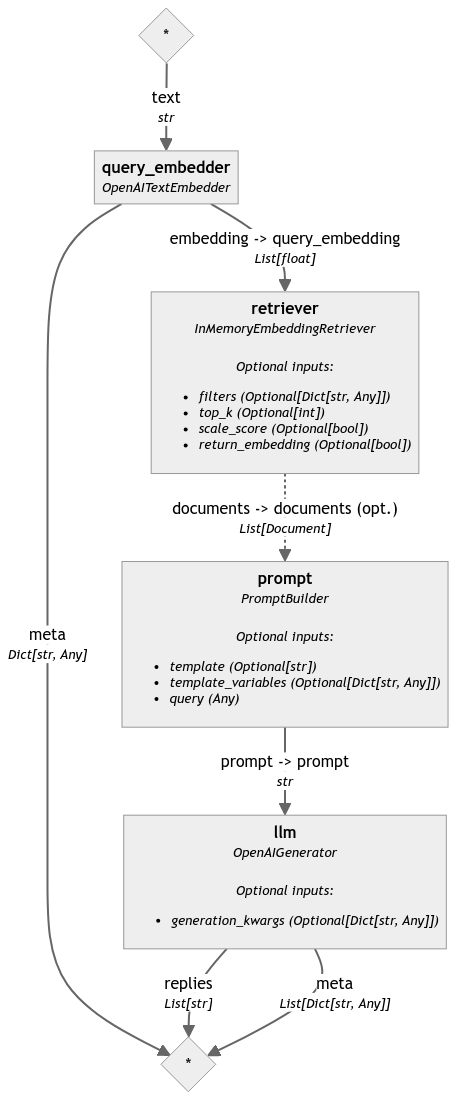

In [14]:
rag.show()

In [15]:
query = "What are the available Mistral components?"
rag.run({"query_embedder": {"text": query},
         "prompt": {"query": query}})

{'query_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 8, 'total_tokens': 8}}},
 'llm': {'replies': ['The available Mistral components are the MistralDocumentEmbedder, which creates embeddings for Haystack Documents using Mistral embedding models; the MistralTextEmbedder, which creates embeddings for texts (such as queries) using Mistral embedding models; and the MistralChatGenerator, which uses Mistral chat completion models.'],
  'meta': [{'model': 'gpt-4-0613',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 64,
     'prompt_tokens': 3266,
     'total_tokens': 3330}}]}}

## Self Reflection - Entity Extraction

In [16]:
template = """"Extract entities from the following text
Text: {{ text }} 
The entities should be presented as key value pairs in a JSON object.

{% if entites_to_validate %}
    Here are the entities you extracted: {{entites_to_validate[0]}}
    Have you extracted all possible entities? 
    If yes, say 'done' and return the extracted entites in the next line
    If not, say 'incomplete' and return the entities in the next line
{% endif %}
Entities:
"""

In [17]:
@component
class EntitiesValidator:
    
    @component.output_types(entites_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'done' in replies[0]:
            return {"entities":replies[0].replace('done', '')}
        else:
            print(Fore.RED + "Entities to Validate\n", replies[0])
            return {"entites_to_validate": replies[0]}

In [18]:
prompt_template = PromptBuilder(template=template)
llm = OpenAIGenerator()
entities_validator = EntitiesValidator()

pipeline = Pipeline(max_loops_allowed=10)

pipeline.add_component("prompt_builder", prompt_template)
pipeline.add_component("entities_validator", entities_validator)
pipeline.add_component("llm", llm)

pipeline.connect("prompt_builder.prompt", "llm.prompt")
pipeline.connect("llm.replies", "entities_validator.replies")
pipeline.connect("entities_validator.entites_to_validate", "prompt_builder.entites_to_validate")

🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entites_to_validate -> prompt_builder.entites_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

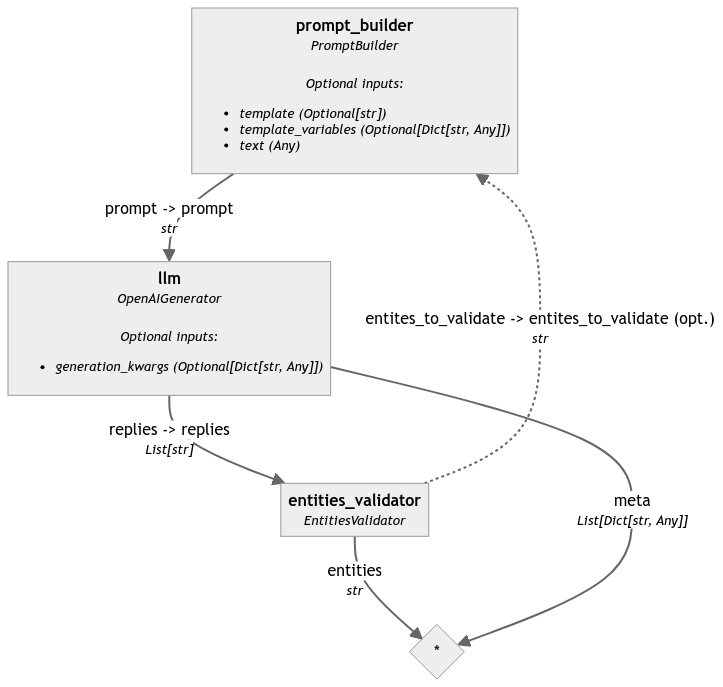

In [19]:
pipeline.show()

In [25]:
text = """
June 19-20, 2024
Paris, France
Composing AI Applications as a Graph with Haystack - Tuana Celik, deepset
There are many moving parts in a fully functioning AI application, whether that be retrieval-augmented generation, agents, chatbots.. Haystack is an open source AI framework in Python, recently redesigned in an opinionated way, that takes the approach of building AI applications as a directed (cyclic) graph. In this talk, we will see how Haystack allows engineers to take full control over how they design their AI workflows, making use of pretty much all model providers and technologies out there.
Speakers
Tuana Celik
Developer Relations Lead, deepset
Tuana is a Developer Advocate at deepset where she focuses on the open source AI community and Haystack, deepset’s open source AI framework. She has been actively involved in helping and maintaining the Haystack developer community and Haystack’s educational materials.
"""

result = pipeline.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Entities to Validate
 {
  "Date": "June 19-20, 2024",
  "Location": "Paris, France",
  "Topic": "Composing AI Applications as a Graph with Haystack",
  "Speaker": "Tuana Celik",
  "Company": "deepset",
  "Role": "Developer Relations Lead",
  "Framework": "Haystack",
  "Language": "Python"
}
{
    "Date": "June 19-20, 2024",
    "Location": "Paris, France",
    "Topic": "Composing AI Applications as a Graph with Haystack",
    "Speaker": "Tuana Celik",
    "Company": "deepset",
    "Role": "Developer Relations Lead",
    "Framework": "Haystack",
    "Programming Language": "Python"
}




## Auto Quizzer

In [20]:
@component
class QuizParser:
    @component.output_types(quiz=Dict)
    def run(self, replies: List[str]):
        reply = replies[0]

        first_index = min(reply.find("{"), reply.find("["))
        last_index = max(reply.rfind("}"), reply.rfind("]")) + 1

        json_portion = reply[first_index:last_index]

        try:
            quiz = json.loads(json_portion)
        except json.JSONDecodeError:
            quiz = json_repair.loads(json_portion)

        if isinstance(quiz, list):
            quiz = quiz[0]
        return {"quiz": quiz}

In [21]:
quiz_generation_template = """Given the following text, create 5 multiple choice quizzes in JSON format.
Each question should have 4 different options, and only one of them should be correct.
The options should be unambiguous.
Each option should begin with a letter followed by a period and a space (e.g., "a. option").
The question should also briefly mention the general topic of the text so that it can be understood in isolation.
Each question should not give hints to answer the other questions.
Include challenging questions, which require reasoning.

respond with JSON only, no markdown or descriptions.

example JSON format you should absolutely follow:
{"topic": "a sentence explaining the topic of the text",
 "questions":
  [
    {
      "question": "text of the question",
      "options": ["a. 1st option", "b. 2nd option", "c. 3rd option", "d. 4th option"],
      "right_option": "c"  # letter of the right option ("a" for the first, "b" for the second, etc.)
    }, ...
  ]
}

text:
{% for doc in documents %}
  {{ doc.content|truncate(4000) }}
{% endfor %}
"""


quiz_generation_pipeline = Pipeline()
quiz_generation_pipeline.add_component("link_content_fetcher", LinkContentFetcher())
quiz_generation_pipeline.add_component("html_converter", HTMLToDocument())
quiz_generation_pipeline.add_component("prompt_builder", PromptBuilder(template=quiz_generation_template))
quiz_generation_pipeline.add_component("generator",OpenAIGenerator(model="gpt-4"))
quiz_generation_pipeline.add_component("quiz_parser", QuizParser())

quiz_generation_pipeline.connect("link_content_fetcher", "html_converter")
quiz_generation_pipeline.connect("html_converter", "prompt_builder")
quiz_generation_pipeline.connect("prompt_builder", "generator")
quiz_generation_pipeline.connect("generator", "quiz_parser")

🚅 Components
  - link_content_fetcher: LinkContentFetcher
  - html_converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - quiz_parser: QuizParser
🛤️ Connections
  - link_content_fetcher.streams -> html_converter.sources (List[ByteStream])
  - html_converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> quiz_parser.replies (List[str])

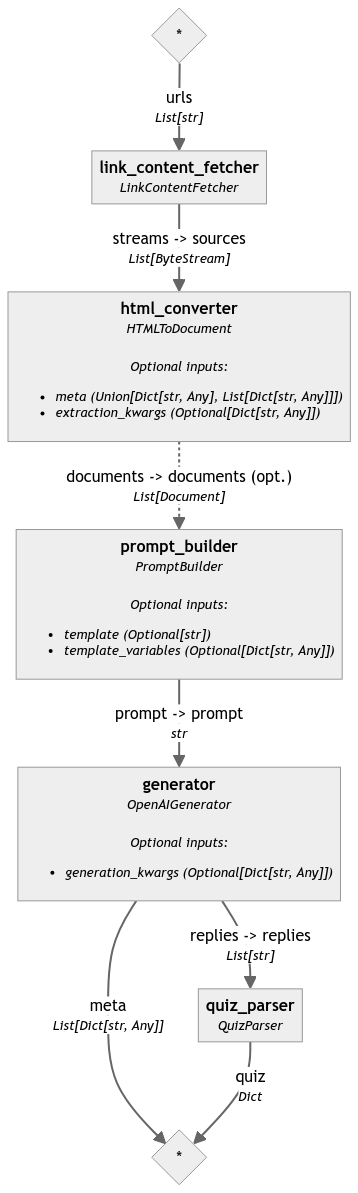

In [22]:
quiz_generation_pipeline.show()

In [11]:
url = "https://www.rainforest-alliance.org/species/capybara/"
quiz = quiz_generation_pipeline.run({"link_content_fetcher": {"urls": [url]}})

print(json.dumps(quiz['quiz_parser']['quiz'], indent=2))

{
  "topic": "Information about Capybaras, including their anatomy, habitat, diet, threats, and interesting facts",
  "questions": [
    {
      "question": "What kind of extremes in size can Capybaras grow up to?",
      "options": [
        "a. They can weigh more than 200 lbs and grow to be 6 feet long and 3 feet tall",
        "b. They can weigh more than 100 lbs and grow to be 4 feet long and 2 feet tall",
        "c. They can weigh more than 50 lbs and grow to be 2 feet long and 1 feet tall",
        "d. They can weigh more than 150 lbs and grow to be 5 feet long and 2.5 feet tall"
      ],
      "right_option": "b"
    },
    {
      "question": "What is the threat posed by humans to Capybaras?",
      "options": [
        "a. Humans pollute their habitats",
        "b. Humans use them for entertainment purposes",
        "c. Humans hunt them for their meat and hide",
        "d. Humans displace them from their natural habitats"
      ],
      "right_option": "c"
    },
    {
  

## Extra: Serialization

In [38]:
pipeline_yaml = quiz_generation_pipeline.dumps()

In [50]:
print(pipeline_yaml)

components:
  generator:
    init_parameters:
      api_base_url: null
      api_key:
        env_vars:
        - OPENAI_API_KEY
        strict: true
        type: env_var
      generation_kwargs: {}
      model: gpt-4
      streaming_callback: null
      system_prompt: null
    type: haystack.components.generators.openai.OpenAIGenerator
  html_converter:
    init_parameters:
      extraction_kwargs: {}
    type: haystack.components.converters.html.HTMLToDocument
  link_content_fetcher:
    init_parameters:
      raise_on_failure: true
      retry_attempts: 2
      timeout: 3
      user_agents:
      - haystack/LinkContentFetcher/2.2.3
    type: haystack.components.fetchers.link_content.LinkContentFetcher
  prompt_builder:
    init_parameters:
      required_variables: null
      template: "Given the following text, create 5 multiple choice quizzes in JSON\
        \ format.\nEach question should have 4 different options, and only one of\
        \ them should be correct.\nThe options 

In [45]:
loaded_pipeline = Pipeline.loads(pipeline_yaml)

In [48]:
url = "https://en.wikipedia.org/wiki/Fiat_Panda"
quiz = loaded_pipeline.run({"link_content_fetcher": {"urls": [url]}})

print(json.dumps(quiz['quiz_parser']['quiz'], indent=2))

{
  "topic": "The overview and history of the Fiat Panda car model",
  "questions": [
    {
      "question": "When did the production of the Fiat Panda start?",
      "options": [
        "a. 1985",
        "b. 1990",
        "c. 2000",
        "d. 1980"
      ],
      "right_option": "d"
    },
    {
      "question": "What is the class of the Fiat Panda?",
      "options": [
        "a. Sports car",
        "b. Full-size car",
        "c. City car/A-segment",
        "d. Luxury car"
      ],
      "right_option": "c"
    },
    {
      "question": "Who were the designers for the first generation Fiat Panda?",
      "options": [
        "a. Giorgetto Giugiaro and Aldo Mantovani",
        "b. Giuliano Biasio",
        "c. Roberto Giolito",
        "d. Carlo De Benedetti"
      ],
      "right_option": "a"
    },
    {
      "question": "When was the third-generation Panda debuted?",
      "options": [
        "a. Frankfurt Motor Show in September 2011",
        "b. Paris Motor Show in